In [5]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

# methods
from gaccord import GraphicalAccord, GraphicalConcord

# utils
import sys
sys.path.append('../utils')
from utils import partial_corr, tp_fp, mcc, precision_recall, pseudo_BIC, gauss_BIC, proj_precision_mat
from generate_graphs import generate_erdos_renyi, generate_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate graph and data (Hub-network)

In [2]:
# we use pre-made hub-network graph structure, which was constructed by the following procedure:
# (1) create a Barabasi-Albert scale-free graph
# (2) randomly choose 5% of the nodes to be hub nodes
# (3) for each hub node, construct a complete sub-graph (clique)
Skel = np.genfromtxt('../data/hub-network-structure.txt', delimiter=',')

n, p = 500, 1000
n_prop_to_p = [0.5]
random_state = 2023
lower_weight, upper_weight = 0.5, 1.0

# projection method
np.random.seed(random_state)
edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
edge_signs = np.random.choice([-1,1], size=(p,p))
Theta = np.multiply(edge_weights, edge_signs)
Theta = np.multiply(Skel, Theta)
Theta = np.tril(Theta) + np.tril(Theta).T
nz_indx = np.nonzero(Theta)
for i in range(100):
    Theta = proj_precision_mat(Theta, nz_indx)
    if np.linalg.cond(Theta) < 20:
        break

Theta = np.real(Theta)
Rho = partial_corr(Theta)
Sigma = np.linalg.inv(Theta)

Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
X = Xs[0]

### Generate graph and data (Erdos-Renyi)

In [2]:
n, p = 500, 1000
n_prop_to_p = [0.5]
Theta, Sigma = generate_erdos_renyi(p, type='proj', edge_prob=0.01, lower_weight=0.5, upper_weight=1.0, spread_diag=[1, np.sqrt(3)], random_state=2023)
Rho = partial_corr(Theta)

Xs = generate_data(p, n_prop_to_p, Sigma, N=1, random_state=2023)
X = Xs[0]

### Select the best $\lambda$ based on pseudo-BIC

In [3]:
S = np.matmul(X.T, X)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 30)

pseudo_bics = []
precs, recalls, mccs = [], [], []

# lams = lams[::-1][14:26] # pre-selected lambdas for hub-network
lams = lams[::-1][7:19] # pre-selected lambdas for erdos-renyi
for lam in lams:
    model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=500)
    model.fit(X)
    Omega_hat = model.omega_.toarray()
    Theta_hat = 0.5 * ((np.diag(np.diag(Omega_hat)) @ Omega_hat) + (Omega_hat.T @ np.diag(np.diag(Omega_hat))))
    pseudo_bic = pseudo_BIC(X, Theta_hat, modified=True, gamma=0.2)
    pseudo_bics.append(pseudo_bic)
    tp, fp = tp_fp(Theta, Theta_hat)
    prec, recall = precision_recall(Theta, Theta_hat)
    precs.append(prec)
    recalls.append(recall)
    mccs.append(mcc(Theta, Theta_hat))
    print('lam:', np.round(lam, 3), ', TP:', tp, ', FP:', fp,\
           ', MCC:', np.round(mcc(Theta, Theta_hat),2),\
           'Precision:', np.round(prec,2),\
           'Recall:', np.round(recall,2),\
           ', p-BIC:', np.round(pseudo_bic, 2))
    
best_lam = lams[np.argmin(pseudo_bics)]

lam: 0.212 , TP: 958 , FP: 0 , MCC: 0.44 Precision: 1.0 Recall: 0.2 , p-BIC: 506959.13
lam: 0.196 , TP: 1481 , FP: 1 , MCC: 0.55 Precision: 1.0 Recall: 0.3 , p-BIC: 502193.81
lam: 0.181 , TP: 1984 , FP: 3 , MCC: 0.63 Precision: 1.0 Recall: 0.41 , p-BIC: 495627.07
lam: 0.167 , TP: 2489 , FP: 31 , MCC: 0.71 Precision: 0.99 Recall: 0.51 , p-BIC: 488605.35
lam: 0.154 , TP: 2950 , FP: 112 , MCC: 0.76 Precision: 0.96 Recall: 0.6 , p-BIC: 481453.71
lam: 0.143 , TP: 3345 , FP: 363 , MCC: 0.78 Precision: 0.9 Recall: 0.68 , p-BIC: 475597.73
lam: 0.132 , TP: 3699 , FP: 894 , MCC: 0.78 Precision: 0.81 Recall: 0.76 , p-BIC: 472621.39
lam: 0.122 , TP: 3961 , FP: 2040 , MCC: 0.73 Precision: 0.66 Recall: 0.81 , p-BIC: 475473.57
lam: 0.112 , TP: 4184 , FP: 4079 , MCC: 0.65 Precision: 0.51 Recall: 0.85 , p-BIC: 487421.26
lam: 0.104 , TP: 4344 , FP: 7314 , MCC: 0.57 Precision: 0.37 Recall: 0.89 , p-BIC: 511047.99
lam: 0.096 , TP: 4463 , FP: 12063 , MCC: 0.49 Precision: 0.27 Recall: 0.91 , p-BIC: 549729.9

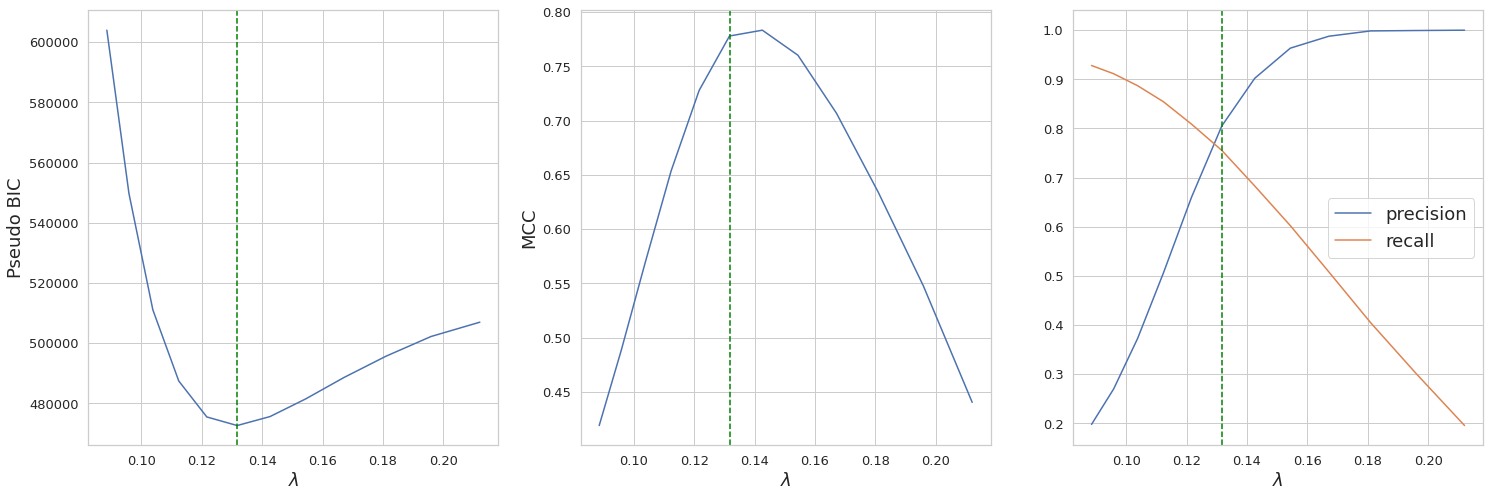

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
axes = axes.ravel()

i = 0
axes[i].plot(lams, pseudo_bics)
axes[i].axvline(best_lam, linestyle='--', color='green')
axes[i].set_xlabel('$\lambda$', fontsize=18)
axes[i].set_ylabel('Pseudo BIC', fontsize=18)
axes[i].tick_params(axis='both', which='major', labelsize=13)

i = 1
axes[i].plot(lams, mccs)
axes[i].axvline(best_lam, linestyle='--', color='green')
axes[i].set_xlabel('$\lambda$', fontsize=18)
axes[i].set_ylabel('MCC', fontsize=18)
axes[i].tick_params(axis='both', which='major', labelsize=13)

i = 2
axes[i].plot(lams, precs, label='precision')
axes[i].plot(lams, recalls, label='recall')
axes[i].axvline(best_lam, linestyle='--', color='green')
axes[i].set_xlabel('$\lambda$', fontsize=18)
axes[i].legend(fontsize=18)
axes[i].tick_params(axis='both', which='major', labelsize=13);

### Refit ACCORD for debiasing

In [5]:
# fit with best lam
model = GraphicalAccord(Omega_star=np.eye(p), lam1=best_lam, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=500)
model.fit(X)
Omega_hat_biased = model.omega_.toarray()
Theta_hat_biased = 0.5 * ((np.diag(np.diag(Omega_hat_biased)) @ Omega_hat_biased) + (Omega_hat_biased.T @ np.diag(np.diag(Omega_hat_biased))))
Rho_hat_biased = partial_corr(Theta_hat_biased)

# refit for debiasing
lam_mat = np.where(Theta_hat_biased != 0, 0, 1000.0)
model = GraphicalAccord(Omega_star=np.eye(p), lam1=lam_mat, stepsize_multiplier=1.0, backtracking=True, epstol=1e-7, maxitr=500)
model.fit(X)
Omega_hat_debiased = model.omega_.toarray()
Theta_hat_debiased = 0.5 * ((np.diag(np.diag(Omega_hat_debiased)) @ Omega_hat_debiased) + (Omega_hat_debiased.T @ np.diag(np.diag(Omega_hat_debiased))))
Rho_hat_debiased = partial_corr(Theta_hat_debiased)

### Summarize results

In [6]:
# get TP/FP indices
Rho_bool = np.where(Rho != 0, 1, 0)
Rho_hat_bool = np.where(Rho_hat_biased != 0, 1, 0)

mask = np.tri(p, p, k=-1, dtype=bool)
edge_true = Rho_bool[mask]
edge_hat = Rho_hat_bool[mask]
TP_indx = np.where((edge_true == 1) & (edge_hat == 1) == 1)[0]
FP_indx = np.where((edge_true == 0) & (edge_hat == 1) == 1)[0]

In [7]:
rho_true = Rho[mask]
rho_biased = Rho_hat_biased[mask]
rho_debiased = Rho_hat_debiased[mask]

print(' - Biased Metrics')
print('Fro. Norm squared of TPs:', np.linalg.norm(rho_true[TP_indx] - rho_biased[TP_indx])**2)
print('Fro. Norm squared of FPs:', np.linalg.norm(rho_true[FP_indx] - rho_biased[FP_indx])**2)
print('Fro. Norm squared of total:', np.linalg.norm(rho_true - rho_biased)**2)
print('Average Fro. Norm squared of TPs:', (np.linalg.norm(rho_true[TP_indx] - rho_biased[TP_indx])**2)/len(TP_indx))
print('Average Fro. Norm squared of FPs:', (np.linalg.norm(rho_true[FP_indx] - rho_biased[FP_indx])**2)/len(FP_indx))
print(' ')
print(' - Debiased Metrics')
print('Fro. Norm squared of TPs:', np.linalg.norm(rho_true[TP_indx] - rho_debiased[TP_indx])**2)
print('Fro. Norm squared of FPs:', np.linalg.norm(rho_true[FP_indx] - rho_debiased[FP_indx])**2)
print('Fro. Norm squared of total:', np.linalg.norm(rho_true - rho_debiased)**2)
print('Average Fro. Norm squared of TPs:', (np.linalg.norm(rho_true[TP_indx] - rho_debiased[TP_indx])**2)/len(TP_indx))
print('Average Fro. Norm squared of FPs:', (np.linalg.norm(rho_true[FP_indx] - rho_debiased[FP_indx])**2)/len(FP_indx))

 - Biased Metrics
Fro. Norm squared of TPs: 36.64680029499795
Fro. Norm squared of FPs: 0.12505400257680516
Fro. Norm squared of total: 52.06410136682949
Average Fro. Norm squared of TPs: 0.009907218246822912
Average Fro. Norm squared of FPs: 0.0001398814346496702
 
 - Debiased Metrics
Fro. Norm squared of TPs: 4.104185714325972
Fro. Norm squared of FPs: 11.315338798368261
Fro. Norm squared of total: 30.711771581948963
Average Fro. Norm squared of TPs: 0.0011095392577253236
Average Fro. Norm squared of FPs: 0.012656978521664721


In [8]:
# get nonzero partial correlations
true_nonzeros = rho_true[rho_true!=0]
biased_nonzeros_TP = rho_biased[TP_indx]
biased_nonzeros_FP = rho_biased[FP_indx]
debiased_nonzeros_TP = rho_debiased[TP_indx]
debiased_nonzeros_FP = rho_debiased[FP_indx]

In [9]:
# save results (hub-network)
# np.savetxt('data/true_nonzeros_hub.txt', true_nonzeros, fmt='%s', delimiter=',')
# np.savetxt('data/biased_nonzeros_tp_hub.txt', biased_nonzeros_TP, fmt='%s', delimiter=',')
# np.savetxt('data/biased_nonzeros_fp_hub.txt', biased_nonzeros_FP, fmt='%s', delimiter=',')
# np.savetxt('data/debiased_nonzeros_tp_hub.txt', debiased_nonzeros_TP, fmt='%s', delimiter=',')
# np.savetxt('data/debiased_nonzeros_fp_hub.txt', debiased_nonzeros_FP, fmt='%s', delimiter=',')

# save results (erdos-renyi)
# np.savetxt('data/true_nonzeros_er.txt', true_nonzeros, fmt='%s', delimiter=',')
# np.savetxt('data/biased_nonzeros_tp_er.txt', biased_nonzeros_TP, fmt='%s', delimiter=',')
# np.savetxt('data/biased_nonzeros_fp_er.txt', biased_nonzeros_FP, fmt='%s', delimiter=',')
# np.savetxt('data/debiased_nonzeros_tp_er.txt', debiased_nonzeros_TP, fmt='%s', delimiter=',')
# np.savetxt('data/debiased_nonzeros_fp_er.txt', debiased_nonzeros_FP, fmt='%s', delimiter=',')

In [2]:
# load results (hub-network)
true_nonzeros_hub = np.genfromtxt('data/true_nonzeros_hub.txt', delimiter=',')
biased_nonzeros_TP_hub = np.genfromtxt('data/biased_nonzeros_tp_hub.txt', delimiter=',')
biased_nonzeros_FP_hub = np.genfromtxt('data/biased_nonzeros_fp_hub.txt', delimiter=',')
debiased_nonzeros_TP_hub = np.genfromtxt('data/debiased_nonzeros_tp_hub.txt', delimiter=',')
debiased_nonzeros_FP_hub = np.genfromtxt('data/debiased_nonzeros_fp_hub.txt', delimiter=',')

# load results (erdos-renyi)
true_nonzeros_er = np.genfromtxt('data/true_nonzeros_er.txt', delimiter=',')
biased_nonzeros_TP_er = np.genfromtxt('data/biased_nonzeros_tp_er.txt', delimiter=',')
biased_nonzeros_FP_er = np.genfromtxt('data/biased_nonzeros_fp_er.txt', delimiter=',')
debiased_nonzeros_TP_er = np.genfromtxt('data/debiased_nonzeros_tp_er.txt', delimiter=',')
debiased_nonzeros_FP_er = np.genfromtxt('data/debiased_nonzeros_fp_er.txt', delimiter=',')

### Visualization (hub-network)

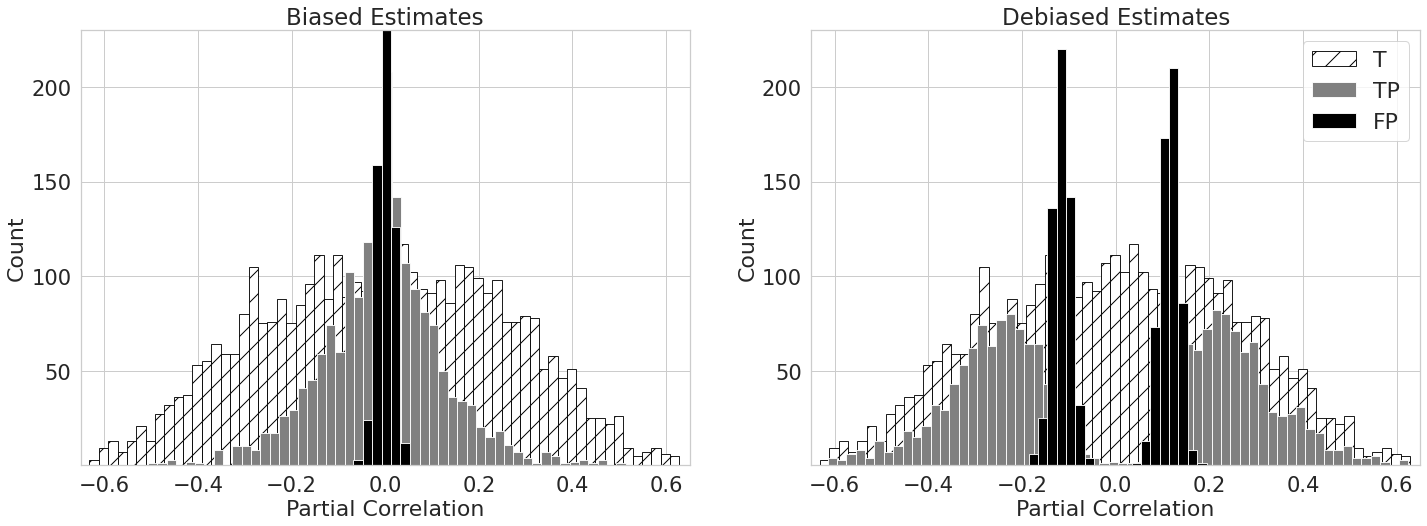

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
axes = axes.ravel()
binwidth=0.02

i = 0
sns.histplot(true_nonzeros_hub, color='1', binwidth=binwidth, alpha=1, hatch='/', edgecolor='black', label='T', ax=axes[i])
sns.histplot(biased_nonzeros_TP_hub, color='0.5', binwidth=binwidth, alpha=1, label='TP', ax=axes[i])
sns.histplot(biased_nonzeros_FP_hub, color='0', binwidth=binwidth, alpha=1, label='FP', ax=axes[i])
axes[i].tick_params(axis='both', which='major', labelsize=21)
axes[i].set_yticks([50, 100, 150, 200])
axes[i].set_title('Biased Estimates', fontsize=23)
axes[i].set_xlabel('Partial Correlation', fontsize=22)
axes[i].set_ylabel('Count', fontsize=22)
axes[i].set_xlim((-0.65,0.65))
axes[i].set_ylim((0,230))

i = 1
sns.histplot(true_nonzeros_hub, color='1', binwidth=binwidth, alpha=1, hatch='/', edgecolor='black', label='T', ax=axes[i])
sns.histplot(debiased_nonzeros_TP_hub, color='0.5', binwidth=binwidth, alpha=1, label='TP', ax=axes[i])
sns.histplot(debiased_nonzeros_FP_hub, color='0', binwidth=binwidth, alpha=1, label='FP', ax=axes[i])
axes[i].tick_params(axis='both', which='major', labelsize=21)
axes[i].set_yticks([50, 100, 150, 200])
axes[i].set_title('Debiased Estimates', fontsize=23)
axes[i].set_xlabel('Partial Correlation', fontsize=22)
axes[i].set_ylabel('Count', fontsize=22)
axes[i].set_xlim((-0.65,0.65))
axes[i].set_ylim((0,230))
axes[i].legend(fontsize=22)

plt.savefig('../output/debiasing-hub-network.png', bbox_inches='tight');

### Visualization (Erdos-Renyi)

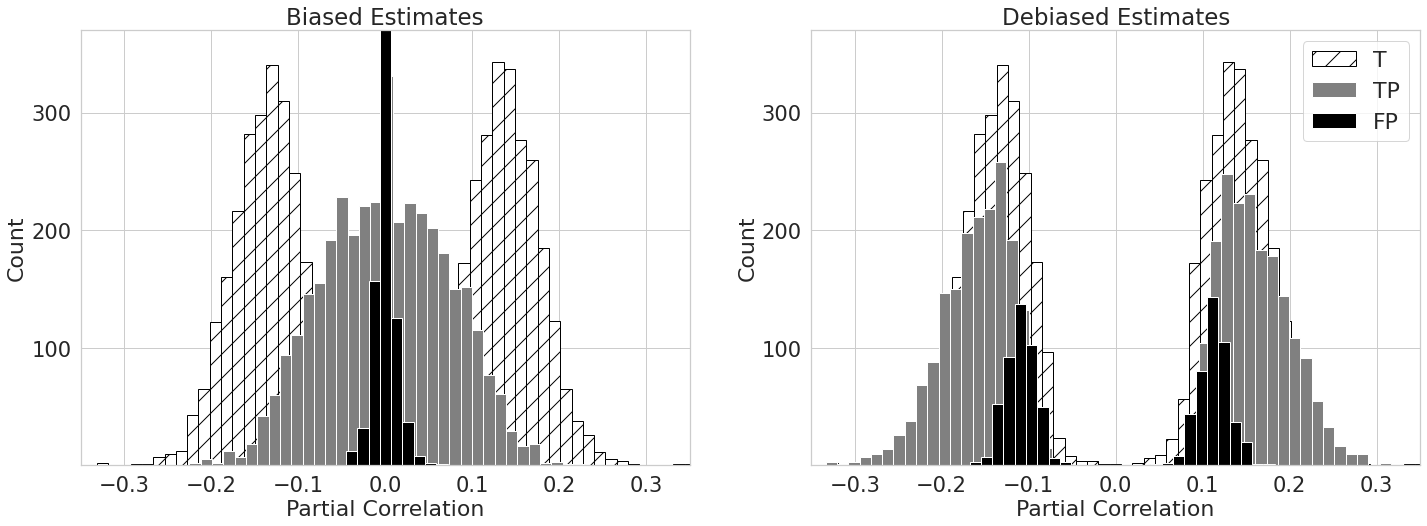

In [7]:
# erdos-renyi
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
axes = axes.ravel()
binwidth=0.013

i = 0
sns.histplot(true_nonzeros_er, color='1', binwidth=binwidth, alpha=1, hatch='/', edgecolor='black', label='T', ax=axes[i])
sns.histplot(biased_nonzeros_TP_er, color='0.5', binwidth=binwidth,  alpha=1, label='TP', ax=axes[i])
sns.histplot(biased_nonzeros_FP_er, color='0', binwidth=binwidth, alpha=1, label='FP', ax=axes[i])
axes[i].tick_params(axis='both', which='major', labelsize=21)
axes[i].set_yticks([100, 200, 300])
axes[i].set_title('Biased Estimates', fontsize=23)
axes[i].set_xlabel('Partial Correlation', fontsize=22)
axes[i].set_ylabel('Count', fontsize=22)
axes[i].set_xlim((-0.35,0.35))
axes[i].set_ylim((0,370))

i = 1
sns.histplot(true_nonzeros_er, color='1', binwidth=binwidth, alpha=1, hatch='/', edgecolor='black', label='T', ax=axes[i])
sns.histplot(debiased_nonzeros_TP_er, color='0.5', binwidth=binwidth, alpha=1, label='TP', ax=axes[i])
sns.histplot(debiased_nonzeros_FP_er, color='0', binwidth=binwidth, alpha=1, label='FP', ax=axes[i])
axes[i].tick_params(axis='both', which='major', labelsize=21)
axes[i].set_yticks([100, 200, 300])
axes[i].set_title('Debiased Estimates', fontsize=23)
axes[i].set_xlabel('Partial Correlation', fontsize=22)
axes[i].set_ylabel('Count', fontsize=22)
axes[i].set_xlim((-0.35,0.35))
axes[i].set_ylim((0,370))
axes[i].legend(fontsize=22)

plt.savefig('../output/debiasing-erdos-renyi.png', bbox_inches='tight');